In [3]:
from qiskit_aer import Aer
import qiskit
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from scipy import sparse, linalg

In [16]:
def construct_qcc_circuit(entanglers, params, truncation=None, barrier=False):
    '''This function defines the exponential building block for Hamiltonian simulation. 
    
    Args:
        entanglers: list storing Pauli words for construction of qcc_circuit.
        params: parameters for the rotations in blocks
    Returns:
        qcc_circuit
    '''

    
    if truncation is not None:
        if len(entanglers) > truncation:
            num_blocks = truncation
        else:
            num_blocks = len(entanglers)
    else:
        num_blocks = len(entanglers)
    
    num_qubits = len(entanglers[0])
    qcc_circuit = QuantumCircuit(num_qubits)

    # Add Hadamard gates at the beginning of the circuit <--------HERE
    for qubit in range(num_qubits):
        qcc_circuit.h(qubit)

    for i in range(num_blocks):
        circuit = QuantumCircuit(num_qubits)
        key = entanglers[i]
        coupler_map = []
        # We first construct coupler_map according to the key.
        for j in range(num_qubits):
            if key[num_qubits-1-j] != 'I':
                coupler_map.append(j)
                
        # Then we construct the circuit.
        if len(coupler_map) == 1:
            # there is no CNOT gate.
            c = coupler_map[0]
    
            if key[num_qubits-1-c] == 'X':
                circuit.h(c)
                circuit.rz(params[i], c) #HERE
                circuit.h(c)
            elif key[num_qubits-1-c] == 'Y': 
                circuit.sdg(c)
                circuit.h(c)
                circuit.rz(params[i], c) #HERE
                circuit.h(c)
                circuit.s(c)
            elif key[num_qubits-1-c] == 'Z':
                circuit.rz(params[i], c) #HERE
                
            qcc_circuit.compose(circuit, inplace=True)
        else:
            # Here we would need CNOT gate.
            for j in coupler_map:
                if key[num_qubits-1-j] == 'X':
                    circuit.h(j)
                elif key[num_qubits-1-j] == 'Y':
                    circuit.sdg(j)
                    circuit.h(j)
                    
            for j in range(len(coupler_map) - 1):
                circuit.cx(coupler_map[j], coupler_map[j+1])
                
            param_gate = QuantumCircuit(num_qubits)
            param_gate.rz(params[i], coupler_map[-1])
            
            qcc_circuit.compose(circuit, inplace=True)
            qcc_circuit.compose(param_gate, inplace=True)
            qcc_circuit.compose(circuit.inverse(), inplace=True)

        if barrier is True:
            qcc_circuit.barrier()
    
    return qcc_circuit

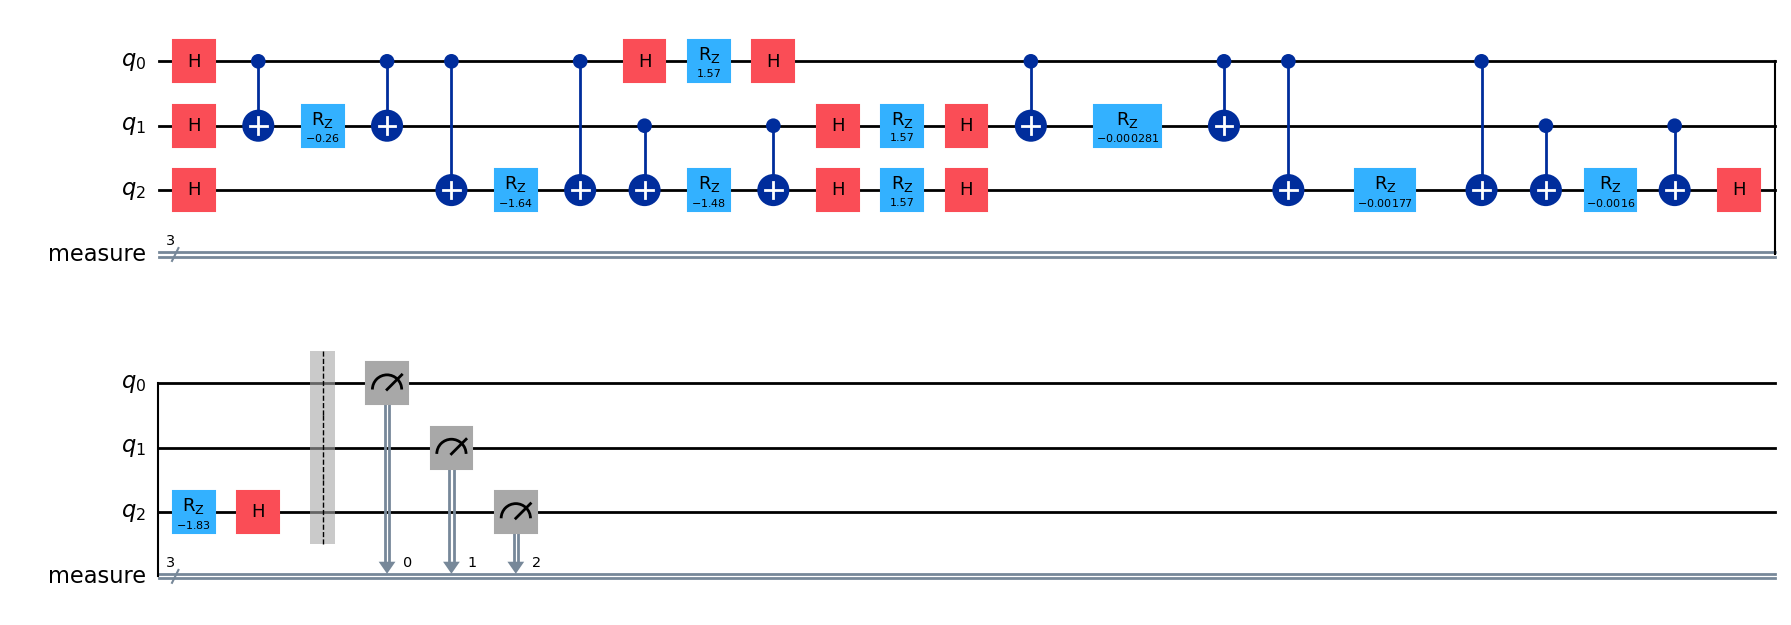

In [17]:
# Cost Hamiltonian Weight Parameters
w1 = 0.13436424411240122
w2 = 0.8474337369372327
w3 = 0.763774618976614

#In order to get the correct results, you have to multiple the cost parm by -1 and the mixer parm by 2



# Layer 1 of 1

# L1_mix_parm = 0.3583442628434307*2
# L1_cost_parm = 1.161386834959433*-1

# Mixer Values
# pauli_strings = ['IIX','IXI','XII']
# coefficients = [2*L1_mix_parm]*3

# Cost Values
# pauli_strings = ['IZZ', 'ZIZ', 'ZZI']
# coefficients = [w1*-L1_cost_parm, w2*-L1_cost_parm, w3*-L1_cost_parm]

# Combined Operations
# pauli_strings = ['IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII']
# coefficients = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3





# Layer 1 of 2

# L1_mix_parm = 0.7872782689900396*2
# L1_cost_parm = 1.9380388913934923*-1

# Mixer Values
# pauli_strings = ['IIX','IXI','XII']
# coefficients = [2*L1_mix_parm]*3

# Cost Values
# pauli_strings = ['IZZ', 'ZIZ', 'ZZI']
# coefficients = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm]


# pauli_strings = ['IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII']
# coefficients = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3



# Layer 2 of 2

# L2_mix_parm = -0.9174947695641181*2
# L2_cost_parm = 0.002092886022676208*-1

# Mixer parameters
# pauli_strings = ['XII'] #this is X2????
# coefficients = [L2_mix_parm]

# Cost parameters
# pauli_strings = ['IZZ', 'ZIZ', 'ZZI']
# coefficients = [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] 

# Combined Operations
# pauli_strings = ['IZZ', 'ZIZ', 'ZZI','XII']
# coefficients = [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] +[L2_mix_parm]


w1 = 0.13436424411240122
w2 = 0.8474337369372327
w3 = 0.763774618976614
L1_mix_parm = 0.7872782689900396*2
L1_cost_parm = 1.9380388913934923*-1
L2_mix_parm = -0.9174947695641181*2
L2_cost_parm = 0.002092886022676208*-1

pauli_strings = ['IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII','IZZ', 'ZIZ', 'ZZI','XII']
coefficients = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3 + [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] +[L2_mix_parm]

# pauli_strings = ['IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII','IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII']
# coefficients = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3 + [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] +[L2_mix_parm]*3

# pauli_strings = ['IZZ', 'ZIZ', 'ZZI','XII']
# coefficients  = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3 + [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] +[L2_mix_parm]*3




origin_qc = construct_qcc_circuit(entanglers = pauli_strings, params = coefficients, barrier=False)
origin_qc.measure_active()


# origin_qc.save_unitary()

# simulator = AerSimulator(method = 'unitary')
# circ = transpile(origin_qc, simulator)

# # Run and get unitary
# result = simulator.run(circ).result()
# unitary = result.get_unitary(circ)
# # print("Circuit unitary:\n", np.asarray(unitary).round(10))

# print("Circuit Matrix :\n",sparse.csr_matrix(unitary.data))


origin_qc.draw("mpl")


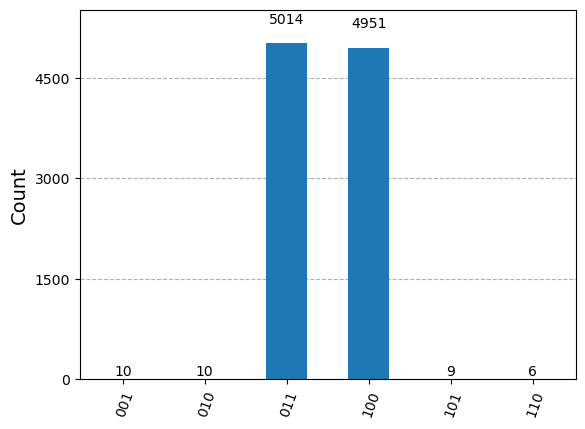

In [18]:
#Display Probability histogram
# only works if you measure the putcome of the circuit

simulator = AerSimulator()
result = simulator.run(origin_qc, shots = 10000).result()


# Plot the orignal probs histogram
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
counts = result.get_counts()
plot_histogram(counts)


